# Final deliverable
This is the notebook that has the final info.

There is some story information, but we did this notebook under the assumption that it's mainly to display graphs, how we got them, logic behind the code, that kind of thing. The actual story in detail will be kept in the main readme.

Table of Contents <br>

0. Import Modules
1. Data reading
2. Descriptive data analysis
3. Ways to enrich, filter, transform the data
4. Plan and Ideas for Methods

# 0. Import modules
Feel free to use the virtual environment (amonavis) included in the GitHub folder.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns
import statistics
import math

# networkx
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout


# For semantic similarity
from urllib.parse import unquote
from transformers import BertTokenizer
from transformers import BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Python functions in .py file to read data
import data_readers

import warnings
from tqdm import TqdmWarning
warnings.filterwarnings('ignore', category=TqdmWarning)

# 1. Data reading
The following code reads the data and saves them in the appropriate variables.
<br><br>
**Wikispeedia**
This will hold our graph where Wikipedia articles are nodes and links/paths between them are edges.

<br><br>
**finished_paths**
The datafile includes the hashedIpAddress, timestamp, durationInSec, path, and rating of games that were completed.
We also add columns with the first article (soruce), last article (target), path length (#articles), and a readable date in Timestamp format.

<br><br>
**unfinished_paths**
This datafile is similar to finished_paths, but with games that weren't completed. It has the hashedIpAddress, timestamp, durationInSec, path, target, and type of failure (either timeout or restart).

<br><br>
**articles**
Dataframe with the name of all articles in the dataset.

<br><br>
**categories**
This shows the higher category classification of each article. For example, Áedán mac Gabráin is part of 'subject.History.British_History.British_History_1500_and_before_including_Roman_Britain'

In [2]:
# The links and edges
wikispeedia = data_readers.read_wikispeedia_graph()

# The finished paths
finished_paths = data_readers.read_finished_paths()

# The unfinished paths
unfinished_paths = data_readers.read_unfinished_paths()

# DF of all articles
articles = data_readers.read_articles()

# DF of all articles and their categories
categories = data_readers.read_categories()

# We found out later that the data contained in the shortest path matrix given to us seems to be wrong
# Here we also add a quick dictionary that properly shows that this is wrong, and give an example
shortest_path_df = data_readers.read_shortest_path_df()
shortest_path_dict = dict(nx.all_pairs_shortest_path(wikispeedia))

# Searching for the string of a given article. It has to be formatted like the article name
# Which shouldn't be a problem, as we'll probably usually retrieve them internally
obi_wan_text = data_readers.plaintext_article_finder('Obi-Wan_Kenobi')

These are less nodes than the reported number, it should be 4,604 nodes.

The 119,882 edges is correct though.

The difference is probably due to some nodes not being connected to the rest of the graph, as here we read in only the articles that are connected. The few nodes that we are losing do not matter for what we need.

# 2. Initial Descriptive Data Analysis
Here, we show that we understand what’s in the data (formats, distributions, missing values, correlations, etc.).


In this section:
<br>2.1. How many articles there are, how many paths 
<br>2.2. Histograms of the links from each article (for example, how many articles have 20 links, etc)
<br>2.3. PageRank
<br>2.4. Average distance from one article to any other article
<br>2.5. Histogram of the number of games at each point in time
<br>2.6. Understanding unfinished games: Categories of targets in unfinished games
<br>2.7. Issue with the shortest path
<br>2.8. Study of Unique paths
<br>2.9. Study of hubs
<br>2.10. DataFrame and spreadsheet creation 

### 2.1. How many: articles, links, finished games, unfinished games?


In [3]:
print("There are", len(wikispeedia.nodes), "articles in the dataset.")
print("There are", len(wikispeedia.edges), "links/paths.")
print("There are", finished_paths.shape[0], "finished games.")
print("There are", unfinished_paths.shape[0], "unfinished games.")

There are 4592 articles in the dataset.
There are 119882 links/paths.
There are 51318 finished games.
There are 24875 unfinished games.


These are less nodes than the reported number, it should be 4,604 nodes.

The 119,882 edges is correct though.

The difference is probably due to some nodes not being connected to the rest of the graph, as here we read in only the articles that are connected. The few nodes that we are losing do not matter for what we need.

In [4]:
# This is sample code for how to do the plotply plots, important for later

# import plotly.graph_objects as go
# 
# # Coordinates and sizes for the circles
# x_values = [0, 1]
# y_values = [1, 1]
# circle_sizes = [50, 100]  # Sizes of the circles
# 
# # Create a Plotly scatter plot with circles
# fig = go.Figure()
# 
# fig.add_trace(go.Scatter(
#     x=x_values,
#     y=y_values,
#     mode='markers',
#     marker=dict(size=circle_sizes,
#                 sizemode='diameter',  # Use the size value directly as diameter
#                 color=['blue', 'red'],  # Colors of the circles
#                 opacity=0.5,  # Adjust opacity if needed
#                 line=dict(width=2),  # Adjust circle border width
#                 symbol='circle',  # Use 'circle' symbol
#                 showscale=False  # Disable the color scale
#                )
# ))
# 
# # Update layout to hide x and y axes
# fig.update_layout(
#     title='Two Circles with Different Sizes',
#     xaxis=dict(showgrid=False, zeroline=False, visible=False),  # Hide x axis
#     yaxis=dict(showgrid=False, zeroline=False, visible=False),  # Hide y axis
#     showlegend=False,
#     hovermode='closest'
# )
# 
# # Show the plot
# fig.show()


In [5]:
unique_paths = finished_paths['path'].unique()
print('There are', len(unique_paths), 'unique finshed paths in the dataset')

There are 47856 unique finshed paths in the dataset


### 2.2. Degree of a Node
We first want to get an idea of the node degree distribution

The degree of a node is the number of edges/links it has. We plot a complementary cumulative distribution function (CCDF) of degree for each article/node, using a log log scale.

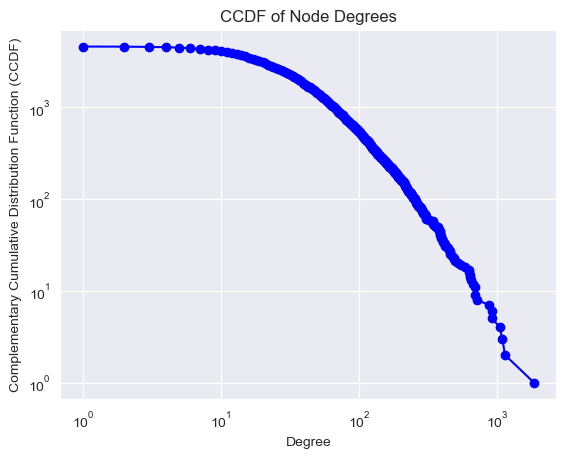

In [6]:
# Get the degrees of all nodes
degrees = dict(wikispeedia.degree())

# Calculate the CCDF
degree_values = sorted(set(degrees.values()), reverse=True)
ccdf = [sum(1 for degree in degrees.values() if degree >= d) for d in degree_values]

# Plot the CCDF
plt.plot(degree_values, ccdf, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Complementary Cumulative Distribution Function (CCDF)')
plt.title('CCDF of Node Degrees')
plt.show()

What are the "hubs"? Which nodes have more than 500 links?

In [7]:
art_more1000 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 1000]
art_500_1000 = [node for node in wikispeedia.nodes if (wikispeedia.degree(node) >= 500)&(wikispeedia.degree(node) < 1000)]
art_300_500 = [node for node in wikispeedia.nodes if (wikispeedia.degree(node) >= 300)&(wikispeedia.degree(node) < 500)]

print("Nodes with > 1000 edges: ", len(art_more1000), "nodes ||||", art_more1000)
print('')
print("Nodes with 500-1000 edges: ", len(art_500_1000), "nodes ||||", art_500_1000)
print('')
print("Nodes with 300-500 edges:  ", len(art_300_500), "nodes ||||", art_300_500)

Nodes with > 1000 edges:  4 nodes |||| ['United_Kingdom', 'France', 'United_States', 'Europe']

Nodes with 500-1000 edges:  16 nodes |||| ['Russia', 'World_War_II', 'Germany', 'Italy', 'Canada', 'English_language', 'England', 'Spain', 'India', 'China', 'Australia', 'Japan', 'London', 'Africa', 'Animal', 'Scientific_classification']

Nodes with 300-500 edges:   47 nodes |||| ['Ireland', 'Scotland', '20th_century', 'Currency', 'European_Union', 'List_of_countries_by_system_of_government', 'Sweden', 'Time_zone', 'Netherlands', 'Paris', 'Atlantic_Ocean', 'Greece', 'Portugal', 'Soviet_Union', 'United_Nations', 'Mexico', 'Poland', '19th_century', 'North_America', 'Iran', 'Asia', 'Islam', 'Christianity', 'Jew', 'Earth', 'Water', 'Brazil', 'Egypt', 'Roman_Catholic_Church', 'New_York_City', 'New_Zealand', 'South_Africa', 'South_America', 'Israel', 'People%27s_Republic_of_China', 'Human', 'World_War_I', 'Argentina', 'Lebanon', 'Turkey', 'German_language', 'Latin', 'French_language', 'List_of_cou

Observe that biggest hubs are mainly countries. The 'United Kingdom', 'France', 'United States', and 'Europe' have over 1000 links. Since there are 4592 nodes, these nodes have link to almost 1/4 of the dataset!

Another way of measuring hubs is this concept called betweenness centrality. The idea is that if we imagine paths as a message flowing, the nodes that form bottlenecks of the graph have the highest value for this. We will only print 40 of them to keep visuals manageable

In [8]:
pd.Series(nx.betweenness_centrality(wikispeedia))[:40]

KeyboardInterrupt: 

How many nodes have more than 20 links? How many have only 1 link?

In [ ]:
# Get the percentages
total_nodes = len(wikispeedia.nodes)
print('Total number of nodes:', total_nodes, '\n')

# Count the number of nodes with degree 1
nodes_degree_1 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) == 1]
print('Nodes with degree 1: ',len(nodes_degree_1), "nodes ||||", nodes_degree_1)
# print percentage over total
print('Percentage of nodes with degree 1: ', len(nodes_degree_1) / total_nodes, '\n')

percentage_degree_1 = (len(nodes_degree_1) / total_nodes)
#print('% of nodes that have only 1 edge/link:', percentage_degree_1)

# Count number of nodes with degree <= 20
nodes_degree_20 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) <= 20]
print('Nodes with degree <=20: ',len(nodes_degree_20))
print('Percentage of nodes with degree <=20: ', len(nodes_degree_20) / total_nodes)

### 2.3. PageRank

PageRank Dictionary: {key: value} -> {'article_title': pagerank}

In [ ]:
dic = nx.pagerank(wikispeedia)
print(dic)

Assign pagerank as a node attribute of Wikispeedia graph

In [ ]:
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['pagerank'] = dic[node]
print(wikispeedia.nodes(data=True))

Average PageRank

In [ ]:
average = sum(dic.values()) / len(dic)
print(average)

In [ ]:
above_average = {key: value for key, value in dic.items() if value >= average}

In [ ]:
num_elements_above_avg = len(above_average)
print("Number of elements above average")
print(num_elements_above_avg)

Median PageRank

In [ ]:
values = list(dic.values())
median = statistics.median(values)
print(median)

In [ ]:
# order dictionary to visualize articles following plot
above_median = {key: value for key, value in dic.items() if value >= median}
above_median_ordered = {k: v for k, v in sorted(above_median.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
num_elements_above_median = len(above_median)
print('Number of elements above average median')
print(num_elements_above_median)

#### PageRank in descending order of the articles above the median (50% data)

In [ ]:
names = list(above_median_ordered.keys())
values = list(above_median_ordered.values())

plt.figure(figsize=(30, 350))
sns.barplot(x=values, y=names, palette='viridis')
plt.xlabel('PageRank')
plt.ylabel('Articles')
plt.title('PageRank Classification of Wikispeedia Articles above the Wikispeedia median PageRank')
# plt.show()

@daniele

In [ ]:
n = 40
names_top_n = names[:n]
values_top_n = values[:n]

fig = go.Figure(go.Bar(
    x=values_top_n,
    y=names_top_n,
    orientation='h',  # 'h' for horizontal, 'v' for vertical bars
     # Adjust colors here
))

fig.update_layout(
    title='PageRank of Top 40 Wikispeedia Articles',
    xaxis_title='PageRank',
    yaxis_title='Articles',
    height=800,  # Adjust the height of the plot as needed
    margin=dict(l=150),  # Adjust left margin for longer y-axis labels
)
fig.show()

### 2.4. Average Distance between Articles
On average, how many links/edges does it take to connect any random two articles?

In [ ]:
# Our graph is not strongly connected, meaning it's not possible to reach every node from every other node
# So we can't use the built in function nx.average_shortest_path_length

# This takes a long time to run (30 sec)
shortest_paths = list(nx.all_pairs_shortest_path_length(wikispeedia))
reachable_pairs = [(source, target, length) for source, paths in shortest_paths for target, length in paths.items() if length != float('inf')]
total_distances = sum(length for _, _, length in reachable_pairs)
average_distance = total_distances / len(reachable_pairs) if reachable_pairs else 0
print(f"Average distance between reachable nodes: {average_distance:.2f}")


### 2.5. Games per Time
Histogram of the number of games at each point in time.


In [ ]:
# Convert timestamps to datetime objects
timestamps = finished_paths['timestamp']
date_times = [datetime.utcfromtimestamp(ts) for ts in timestamps]

# Create a histogram of timestamps
plt.hist(date_times, bins=20, color='skyblue')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

A lot of games were played in Q3 2009! 

In [ ]:
q3_2009_times = [dt for dt in date_times if dt.year == 2009 and dt.month in [7, 8, 9]]
percent_q3_2009_times = len(q3_2009_times) / len(date_times)
print(f"Percent of finished games completed in Q3 2009: {percent_q3_2009_times:.2f}")


### 2.6. Which categories of games are more likely to be unfinished? 

In [ ]:
print('There are', categories['article'].duplicated().sum(), 'articles with more than 1 category.')

print('Should we drop the duplicate categories, or doublecount them?')
print('This corresponds to', categories['article'].duplicated().sum() / len(wikispeedia.nodes), 'of the articles.')

# Let's drop them for now.
categories['article'] = categories['article'].drop_duplicates()
print('The new shape is: ',categories.shape)

# Why are there more articles here than nodes (# articles)?

In [ ]:
# Let's use string manipulation to extract the highest level category for each article.

sub_categories = categories['categories'].str[8:].str.split('.')
category_depth_1 = sub_categories.apply(lambda x: x[0])
categories['depth_1'] = category_depth_1
categories.head()

Let's find the category corresponding to each unfinished target.

In [ ]:
# Merging categories with unfinished paths.
unfinished_paths_with_categories = pd.merge(unfinished_paths, categories, left_on = 'target', right_on= 'article', how = 'left')

# Count the occurrences of each category
category_counts = unfinished_paths_with_categories['depth_1'].value_counts()

# Plotting the bar chart
plt.bar(category_counts.index, category_counts.values)

# Adding labels and title
plt.xlabel('Depth 1 Categories')
plt.ylabel('Frequency')
plt.title('Frequency of Categories of Target Articles in Unfinished Paths')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the plot area

Notice that targets in the science category make up the largest proportion of unfinished games. In Deliverable 3, we will investigate this more. We'll discover if this is because most of the articles are from the science category, or if science articles are actually harder to find in the game.

### 2.7 Issue with the shortest path
The shortest paths that were calculated are wrong. This is just a simple example to show that at least one of the points is wrong. We assume this is common enough elsewhere, as the effort needed to properly prove this is too large.

We double-checked the method for reading in the data, and there are no big changes to be done there. We also double-checked that the graph is a directed graph, which matters for this search. Additionally, we manually checked the edges, so we know that the following example is correct.

In [ ]:
# We have to put the strings into tuples to make this work. It's ugly, but this works
print("Shortest path from Actor to Japan in the given matrix is:", shortest_path_df[('Actor',)][('Japan',)])

print("Shortest path from Actor to Japan according to networkX is:", len(shortest_path_dict['Actor']['Japan'])-1)

print("The actual path is:", shortest_path_dict['Actor']['Japan'])

In [ ]:
# No need to print the entire text, just show that reading it in works
obi_wan_text[:100]

### 2.8. Study of Unique Paths
Here we study the unique source and target pairs. We will use the dataframes to compare the performance between humans and machines, as well as to know what paths to make machines complete.

**article_combinations**

This dataframe contains information on all the combination of source and target articles in the finished games (paths). It includes how many times it has been played, and the mean and std of the path length, duration of the game, and rating.

**unique_targets** and **unique_sources**

These dataframes include all the sources and targets that appears in the finished games

<br><br>
Note that we don't change to ASCII the name of the articles yet. We will do it at a later step if we need to.
<br><br>

In [ ]:
# How many each pair of articles has been visited
article_combinations_count = finished_paths.groupby(['first_article', 'last_article']).size().reset_index(name='count')

# The mean and std of the path length for each pair of articles
article_combinations_stats = finished_paths.groupby(['first_article', 'last_article'])['path_length'].agg(['mean', 'std']).reset_index()
article_combinations_stats['std'] = article_combinations_stats['std'].fillna(0)
article_combinations_stats.rename(columns={'mean': 'mean_length', 'std': 'std_length'}, inplace=True)

# The mean and std of the rating for each pair of articles. 
    # Note that mean and std may be nan if there are nan ratings. We purposely leave them as nan, as we don't want to fill them with 0s or 1s.
    # Depending on the application, we could change this in the future if neeeded.
rating_combinations_stats_rating = finished_paths.groupby(['first_article', 'last_article'])['rating'].agg(['mean', 'std']).reset_index()
#rating_combinations_stats_rating['std'] = rating_combinations_stats_rating['std'].fillna(0)
mask = rating_combinations_stats_rating['mean'].notnull()
rating_combinations_stats_rating.loc[mask, 'std'] = rating_combinations_stats_rating.loc[mask, 'std'].fillna(0)
rating_combinations_stats_rating.rename(columns={'mean': 'mean_rating', 'std': 'std_rating'}, inplace=True)

# The mean and std of the time for each pair of articles.
rating_combinations_stats_time = finished_paths.groupby(['first_article', 'last_article'])['durationInSec'].agg(['mean', 'std']).reset_index()
rating_combinations_stats_time['std'] = rating_combinations_stats_time['std'].fillna(0)
rating_combinations_stats_time.rename(columns={'mean': 'mean_durationInSec', 'std': 'std_durationInSec'}, inplace=True)

# Merging all the dataframes
article_combinations = pd.merge(article_combinations_count, article_combinations_stats, on=['first_article', 'last_article'])
article_combinations = pd.merge(article_combinations, rating_combinations_stats_rating, on=['first_article', 'last_article'])
article_combinations = pd.merge(article_combinations, rating_combinations_stats_time, on=['first_article', 'last_article'])

# The number of unique sources and targets
unique_sources = finished_paths['first_article'].value_counts().reset_index()
unique_targets = finished_paths['last_article'].value_counts().reset_index()

In [ ]:
article_combinations.sample(5)

In [ ]:
unique_sources.sample(5)

In [ ]:
unique_targets.sample(5)

### 2.9. Study of hubs
In the original paper, the authors make a point that hubs are used too commonly by users, and that this might not often be the case for the shortest path.

We want to double check if that holds or not, by checking the number of times a node is used in the paths given in the dataset, versus the number of times they appear in the actual shortest paths.

The only important caveat for this is that the networkX only returns one of the shortest paths, and there might be multiple. It is possible that the different alternate paths give a different result, but for now this is good enough.

In [ ]:
paths_finished = pd.read_csv('datasets/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', skiprows=15,
                             names=['hashedIpAddress', 'timestamp', "durationInSec", 'path', "rating"])

# This is just splitting all the values in paths, and doing a value count for each one of those!
paths_per_step = paths_finished['path'].apply(lambda x: x.split(';')[1:-1])
node_appearance_counts = paths_per_step.explode().value_counts()
node_appearance_counts = node_appearance_counts.rename_axis('Node_Name').reset_index()

# For this, we add the information of the degree of each node, because it's interesting!
degree_dict = dict(wikispeedia.degree())
node_appearance_counts['Degree'] = node_appearance_counts['Node_Name'].map(degree_dict)

node_appearance_counts.plot.scatter('count', 'Degree')
plt.title('Appearances in paths versus degree')

In [ ]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='count ~ Degree', data=node_appearance_counts)

res = mod.fit()
print(res.summary())

Based on the regression analysis, there is a correlation between how often a node is used in the paths and the degree. So this idea of players using a hub is definitely common for the human dataset.

We can also see that there is a high R squared, considering there is only one variable. So the degree does help explain how often it will appear in the paths.

Now, does this actually hold for the shortest paths?

In [ ]:
shortest_path_dict = dict(nx.all_pairs_shortest_path(wikispeedia))

# So, we also remove the first and last element in here
shortest_path_df = pd.DataFrame(shortest_path_dict)
shortest_path_df = pd.melt(shortest_path_df)
# This column is not useful
shortest_path_df = shortest_path_df.drop(['variable'], axis=1)
shortest_path_df = shortest_path_df['value'].dropna()
# This is to remove source and target, to keep the comparison similar
shortest_path_df = shortest_path_df.apply(lambda x: x[1:-1])
# This is to only keep lists that actually have at least one element
shortest_path_df = shortest_path_df[shortest_path_df.map(lambda x: len(x)>0)]

shortest_app_counts = shortest_path_df.explode().value_counts()
shortest_app_counts = shortest_app_counts.rename_axis('Node_Name').reset_index()
shortest_app_counts['Degree'] = shortest_app_counts['Node_Name'].map(degree_dict)

shortest_app_counts.plot.scatter('count', 'Degree')
plt.title('Appearances in paths versus degree shortest paths')

In [ ]:
mod = smf.ols(formula='count ~ Degree', data=shortest_app_counts)

res = mod.fit()
print(res.summary())

While the R squared is lower, it is still quite high in this case. Most importantly, it also shows that there is a correlation between the degree and the number of times it appears in a shortest path!

So this implies that hubs are actually very helpful for finding out the path between two nodes, and are commonly used.

This is something that can be used in our AI, and maybe further in other analysis.

### 2.10. DataFrame and spreadsheet creation 

For future analysis, we may need to filter articles according to some metrics that we may have now or may create in the future. In order to speed up data handling and analysis, we will create the df and store it in a spreadsheet.

In [ ]:
data = {}
# establish article name as index
articles_index = list(wikispeedia.nodes())
df = pd.DataFrame(data, index=articles_index)
# add main column
df['articles'] = articles_index
df['Degree'] = degrees.values()
df['PageRank'] = dic.values()
pd.set_option('display.precision', 15) # add precision to the df
df

Convert it into a excel

In [ ]:
# df.to_excel('wikispeedia.xlsx', index=False)

# 3. Ways to enrich, filter, transform the data

## 3.1 Semantic Similarity

An important part of the project is to study how humans and machines move from article to article. Semantic similarity compares two strings based on a trained model and assigns a value according to how are they correlated (the higher, the more related). For example, 'king' and 'queen' will have a higher semantic similarity than say, 'king' and 'chemistry' (will prove this here).

### Remove the underscore and decode the url

First we define a function that corrects the strings to have a readable format. For example, '%C3%89douard_Manet' is transformed to 'Édouard Manet'.

We will create a function to decode a word, and we will be able to use it in series and dataframes using apply().

In [ ]:
def decode_word(word):
    word = word.replace('_', ' ')
    return unquote(word)

In [ ]:
articles['articles'].head(5)

In [ ]:
articles['articles'].apply(decode_word).head(5)

### Semantic Distance Model
We create a function that returns the semantic similarity between two words you provide.

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# Load a sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Function to get embeddings using sentence transformer
def get_embedding(text):
    return model.encode(text, convert_to_tensor=True)

# Function to perform L2 normalization on the embeddings
def l2_normalize(tensor):
    return tensor / tensor.norm(p=2, dim=0, keepdim=True)

# Function to calculate semantic similarity between two pieces of text
def semantic_similarity(word1, word2):
    embedding1 = get_embedding(word1)
    embedding2 = get_embedding(word2)

    # L2 normalization of the embeddings (to make sure, although embedding should already be normalized)
    embedding1_normalized = l2_normalize(embedding1)
    embedding2_normalized = l2_normalize(embedding2)

    # Compute and return the similarity of normalized tensors
    return torch.dot(embedding1_normalized, embedding2_normalized).item()


In [ ]:
semantic_similarity('king', 'queen')

### Semantic Distance Matrix
Provided a series, it creates a df where indices and column names are the strings of the series, and fills the matrix with the semantic similarity between all words in the provided series.

In [ ]:
def semantic_similarity_matrix(titles):
    df = pd.DataFrame(index=titles, columns=titles)
    for i in range(len(titles)):
        df.iloc[i, i] = 1
        for j in range(i+1, len(titles)):
            df.iloc[i, j] = semantic_similarity(titles[i], titles[j])
            df.iloc[j, i] = df.iloc[i, j]
    return df

In [ ]:
semantic_similarity_matrix(pd.Series(['king', 'queen', 'chemistry', 'biology']))

In [ ]:
articles_decoded = articles['articles'].apply(decode_word)

In [ ]:
def random_sample_articles(n):
    return articles_decoded.sample(n).reset_index(drop=True)

semantic_similarity_matrix(random_sample_articles(10))

### PageRank

Let's create a graph visualization with node size according to the pagerank. 

In [ ]:
nodos_greater_than_average = [n for n, data in wikispeedia.nodes(data=True) if 'pagerank' in data and data['pagerank'] > average]
# let's sort the nodes so that we can visualize the N elements greater than average
N = 60 # to avoid extra computing time try not to establish N higher than 80
# In this case, we chose N = 60 because 
nodes_ordered_per_pagerank = sorted(nodos_greater_than_average, key=lambda n: wikispeedia.nodes[n]['pagerank'], reverse=True)[:N]
# select this nodes from the original Wikispeedia graph 
wavg = wikispeedia.subgraph(nodes_ordered_per_pagerank).copy()
print(wavg)

In [ ]:
def hierarchical_layout(net):
	return graphviz_layout(net, prog="dot")

node_labels = {node: node for node in wavg.nodes()}

pos = hierarchical_layout(wavg)
plt.figure(figsize=(50,50))
nx.draw(wavg,pos, node_size=[(wavg.nodes[n]['pagerank'] * 10500000) for n in wavg], node_color='skyblue', font_weight='bold', with_labels=True, labels=node_labels, font_color='purple', font_size=35, linewidths=8)
plt.title('Above average Pagerank Nodes', fontsize=100)
plt.show()

### Let's draw the nodes with higher degree!

In [ ]:
print(degrees)
higher_degree = 300 # nodes that have at least 300 degree

Assign degree as node attribute of the wikispeedia graph

In [ ]:
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['degree'] = degrees[node]
print(wikispeedia.nodes(data=True))

In [ ]:
nodes_higher_degree = [n for n, data in wikispeedia.nodes(data=True) if 'degree' in data and data['degree'] >= higher_degree]
print(len(nodes_higher_degree))
# there is only 67 nodes with higher degree than 300, let's draw the first 60 to be in accordance with the other drawing and allow comparison

In [ ]:
# let's sort the nodes so that we can visualize the N elements greater than average
N = 60 
nodes_ordered_per_pagerank = sorted(nodes_higher_degree, key=lambda n: wikispeedia.nodes[n]['degree'], reverse=True)[:N]
# select this nodes from the original Wikispeedia graph 
wdegree = wikispeedia.subgraph(nodes_ordered_per_pagerank).copy()
print(wdegree)

In [ ]:
def hierarchical_layout(net):
	return graphviz_layout(net, prog="dot")

node_labels = {node: node for node in wdegree.nodes()}

pos = hierarchical_layout(wdegree)
plt.figure(figsize=(50,50))
nx.draw(wdegree,pos, node_size=[(wdegree.nodes[n]['degree'] *80) for n in wdegree], node_color='orange', font_weight='bold', with_labels=True, labels=node_labels, font_color='purple', font_size=35, linewidths=10)
plt.title('Higher Degree Nodes', fontsize=100)
plt.show()

# 4. Plan and Ideas for Methods


## 4.1 Basic AI using A* Algorigm

Most of the model requires for there to be an AI model we can compare it against.

We were indicated by the TA to not focus on this too much, as this is a data analysis course, not an ML course. Because of this, we took the implementation of A\* that was included in networkX and created two modified versions that now do the following:
- First version returns all of the explored nodes, not just the shortest path found
- Second version is forced to do a depth first search without being able to return

For our purposes, the explored nodes is the most interesting metric, as it describes what were the links "clicked".

We found a paper that implements a more complicated version, and we might be able to do something with graph neural networks, but for now this is good enough.

We additionally do a bit of work to show how the system works timewise, as well as how the comparison will work in the future.

The time comparison is not super useful though, as that will depend on hardware too much to be worth using easily.

In [ ]:
import machine_searchers
import time

def modded_get_embedding(text: str):
    temp_str = text.replace('_', ' ')
    temp_str = unquote(temp_str)
    inputs = tokenizer(temp_str, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def distance_two_words(w1: str, w2: str):
    """Receives a string that was in the wikispeedia dataset, and transforms it as needed to work
    with the berd embeddings."""

    embedding1 = modded_get_embedding(w1)
    embedding2 = modded_get_embedding(w2)
    similarity = cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())[0][0]
    # Adding absolute, just in case it is needed
    # Similarity is actually 1 - abs(similarity) + 1,
    # As we want closer words to have a smaller distance
    # The last plus one is to indicate that there would be an extra cost to exploring, as if not the system often
    # thinks that there are nodes that have a distance of 0.5 or something like that
    similarity = 1 - abs(similarity) + 1
    # print("First word:", w1, ". Second word:", w2, ". GoodDistance:", similarity)
    return similarity

start_time = time.time()
lib_path_1, lib_explore_1 = machine_searchers.modded_astar_path(wikispeedia, 'Actor', 'Japan', heuristic=distance_two_words)
end_time = time.time()

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using the modded a star that returns explored nodes:")
print(" Found solution for Actor to Japan exploring the following number of nodes:", len(lib_explore_1)-1)
print(" Found it in:", end_time-start_time)

start_time = time.time()
lib_path_2, lib_explore_2 = machine_searchers.only_depth_first_astar_path(wikispeedia, 'Actor', 'Japan', heuristic=distance_two_words)
end_time = time.time()

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using depth first only A star that returns explored nodes:")
print(" Found solution for Actor to Japan exploring the following number of nodes:", len(lib_explore_1)-1)
print(" Found it in:", end_time-start_time)


Now we'll take the most commonly explored node pair path, run it through the two algorithms and see what is the result!

In [ ]:
# So it's finding the length between asteroid and viking
article_combinations.sort_values('count', ascending=False).head()

In [ ]:
start_time = time.time()
lib_path_1, lib_explore_1 = machine_searchers.modded_astar_path(wikispeedia, 'Asteroid', 'Viking', heuristic=distance_two_words)
end_time = time.time()

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using the modded a star that returns explored nodes:")
print(" Found solution for Asteroid to Viking exploring the following number of nodes:", len(lib_explore_1)-1)
print("Path length was:", len(lib_path_1)-1)
print(" Found it in:", end_time-start_time)

start_time = time.time()
lib_path_2, lib_explore_2 = machine_searchers.only_depth_first_astar_path(wikispeedia, 'Asteroid', 'Viking', heuristic=distance_two_words)
end_time = time.time()
print('')

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using depth first only A star that returns explored nodes:")
print(" Found solution for Asteroid to Viking exploring the following number of nodes:", len(lib_explore_2)-1)
print("Path length was:", len(lib_path_2)-1)
print(" Found it in:", end_time-start_time)

In [ ]:
lib_path_1

So, based on the previous example of the path, this works out well enough. The systems spends a lot of time exploring and going back, which might be a common issue. There is a huge disconnect between explored and actual path length, but that is common for A\*, so it's an expected caveat.

It is interesting to note that the optimal solution passed through Paris, which seems to fit the definition of being one of the hubs that are described in the paper. Maybe the hub strategy is actually useful in most cases!

The depth first method took a lot longer to run than planned. Based on this, it might be worth considering other alternatives.

But still, at least we've proven the model works, and can give results that we can compare against humans. Again, this is using a much simpler method, but this could be enhanced in the future.